In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, make_scorer
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [30]:
csv_file = pd.read_csv("/content/jm1.csv")

In [31]:
csv_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10885 entries, 0 to 10884
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                10885 non-null  float64
 1   v(g)               10885 non-null  float64
 2   ev(g)              10885 non-null  float64
 3   iv(g)              10885 non-null  float64
 4   n                  10885 non-null  float64
 5   v                  10885 non-null  float64
 6   l                  10885 non-null  float64
 7   d                  10885 non-null  float64
 8   i                  10885 non-null  float64
 9   e                  10885 non-null  float64
 10  b                  10885 non-null  float64
 11  t                  10885 non-null  float64
 12  lOCode             10885 non-null  int64  
 13  lOComment          10885 non-null  int64  
 14  lOBlank            10885 non-null  int64  
 15  locCodeAndComment  10885 non-null  int64  
 16  uniq_Op            108

In [32]:
csv_file[:10]

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1,1,1,1,1,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17,36,112,86,13,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17,135,329,271,5,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11,16,76,50,7,True
5,31.0,2.0,1.0,2.0,111.0,582.52,0.08,12.25,47.55,7135.87,...,19,0,5,0,14,24,69,42,3,True
6,78.0,9.0,5.0,4.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,17,True
7,8.0,1.0,1.0,1.0,16.0,50.72,0.36,2.80,18.11,142.01,...,5,0,1,0,4,5,9,7,1,True
8,24.0,2.0,1.0,2.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,3,True
9,143.0,22.0,20.0,10.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,43,True


Convertir Tipo Objeto a Numerico

In [33]:
object_columns = ['uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
for col in object_columns:
    csv_file[col] = pd.to_numeric(csv_file[col], errors='coerce')

In [34]:
csv_file.isnull().sum()

,0
loc,0
v(g),0
ev(g),0
iv(g),0
n,0
v,0
l,0
d,0
i,0
e,0


In [35]:
csv_file[csv_file.isna().any(axis=1)]


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
143,49.0,4.0,3.0,3.0,185.0,1097.19,0.05,18.84,58.25,20667.93,...,38,0,9,0,NaN,NaN,NaN,NaN,NaN,True
358,27.0,5.0,3.0,3.0,79.0,417.55,0.07,13.52,30.88,5646.37,...,19,0,6,0,NaN,NaN,NaN,NaN,NaN,True
1598,76.0,18.0,11.0,11.0,275.0,1650.00,0.03,34.50,47.83,56925.00,...,62,0,12,0,NaN,NaN,NaN,NaN,NaN,True
4214,6.0,1.0,1.0,1.0,15.0,51.89,0.34,2.92,17.79,151.35,...,3,0,1,0,NaN,NaN,NaN,NaN,NaN,False
8279,9.0,13.0,10.0,4.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,False


Descartar entradas con valores nulos

In [36]:
csv_file = csv_file.dropna()
csv_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10880 entries, 0 to 10884
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                10880 non-null  float64
 1   v(g)               10880 non-null  float64
 2   ev(g)              10880 non-null  float64
 3   iv(g)              10880 non-null  float64
 4   n                  10880 non-null  float64
 5   v                  10880 non-null  float64
 6   l                  10880 non-null  float64
 7   d                  10880 non-null  float64
 8   i                  10880 non-null  float64
 9   e                  10880 non-null  float64
 10  b                  10880 non-null  float64
 11  t                  10880 non-null  float64
 12  lOCode             10880 non-null  int64  
 13  lOComment          10880 non-null  int64  
 14  lOBlank            10880 non-null  int64  
 15  locCodeAndComment  10880 non-null  int64  
 16  uniq_Op            10880 no

Convertir target a entero

In [37]:
csv_file['defects'] = csv_file['defects'].astype(int)
csv_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10880 entries, 0 to 10884
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                10880 non-null  float64
 1   v(g)               10880 non-null  float64
 2   ev(g)              10880 non-null  float64
 3   iv(g)              10880 non-null  float64
 4   n                  10880 non-null  float64
 5   v                  10880 non-null  float64
 6   l                  10880 non-null  float64
 7   d                  10880 non-null  float64
 8   i                  10880 non-null  float64
 9   e                  10880 non-null  float64
 10  b                  10880 non-null  float64
 11  t                  10880 non-null  float64
 12  lOCode             10880 non-null  int64  
 13  lOComment          10880 non-null  int64  
 14  lOBlank            10880 non-null  int64  
 15  locCodeAndComment  10880 non-null  int64  
 16  uniq_Op            10880 no

In [38]:
df_numerico = csv_file.drop(columns=['defects'])

Revisión de distribución de las features

<Figure size 2000x2500 with 0 Axes>

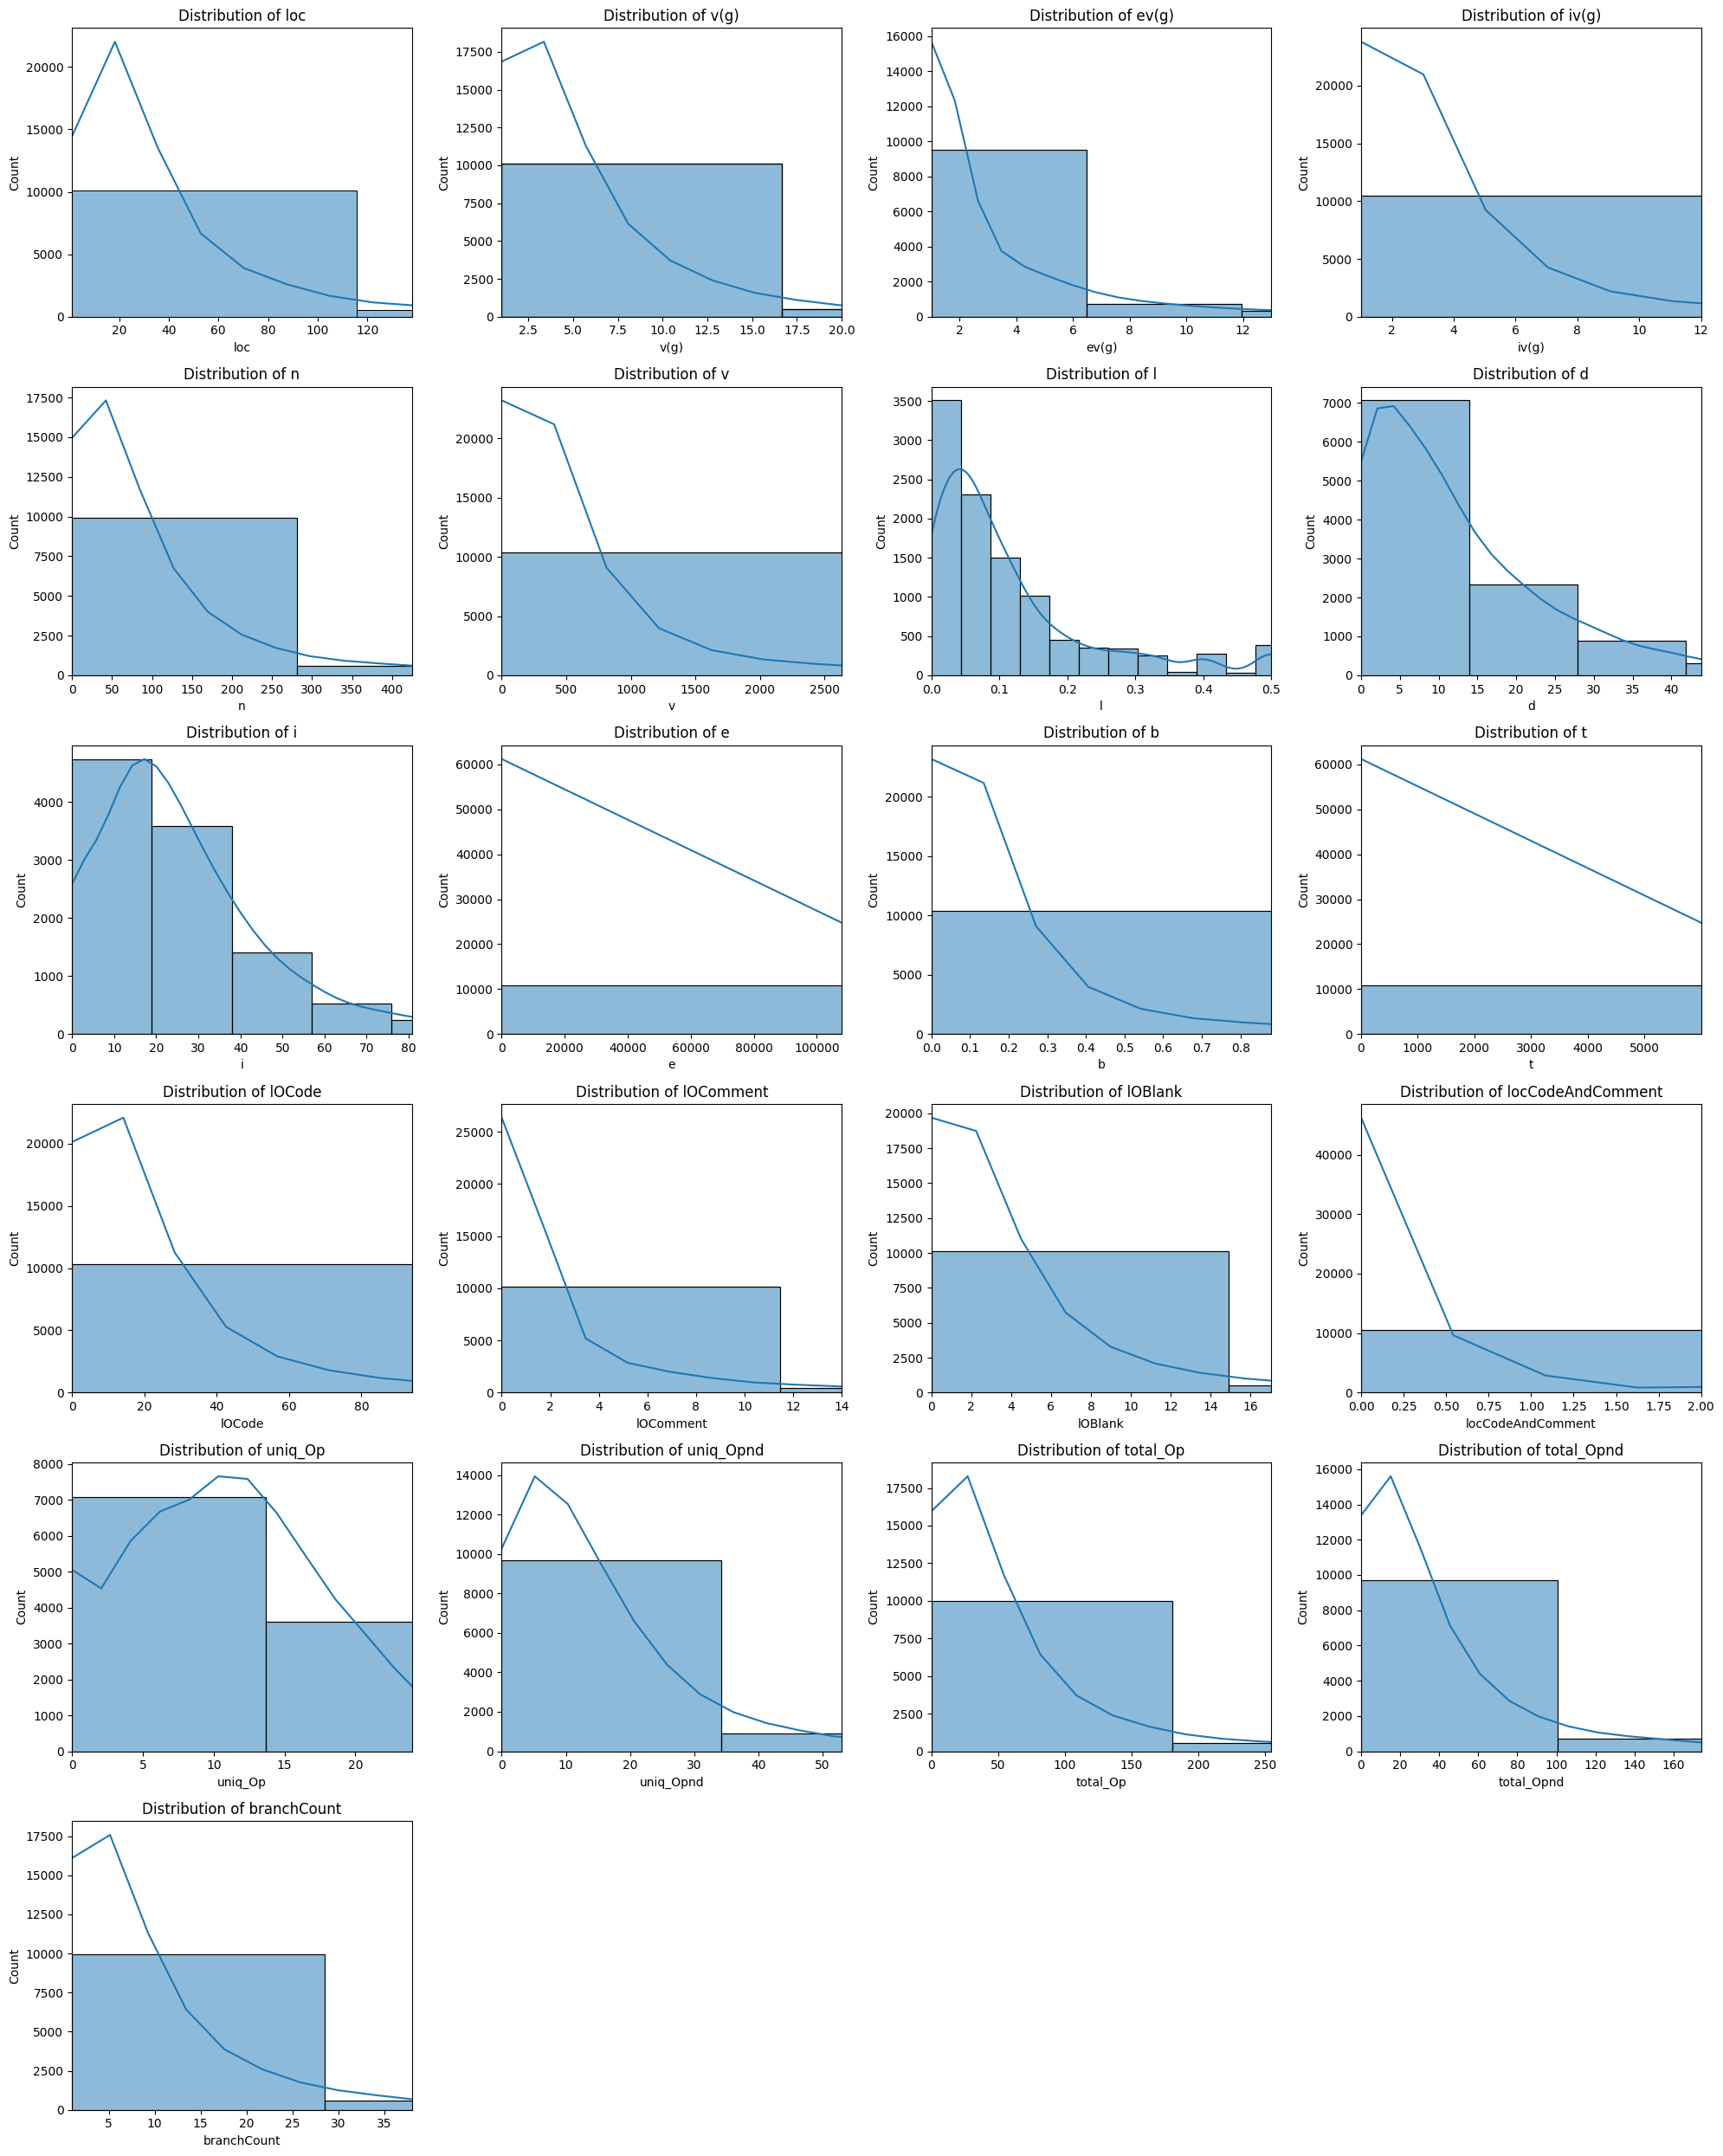

In [39]:
plt.figure(figsize=(20, 25))
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_numerico.columns):
    plt.subplot(6, 4, i + 1)

    # Compute 95th percentile for the column
    xlim = np.percentile(df_numerico[col], 95)

    # Plot with seaborn
    sns.histplot(df_numerico[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlim([df_numerico[col].min(), xlim])  # Apply x-axis limit
    plt.tight_layout()

plt.show()

In [40]:
stats_df = df_numerico.describe().T
stats_df

,count,mean,std,min,25%,50%,75%,max
loc,10880.0,42.020138,76.608641,1.0,11.00,23.000,46.0000,3442.00
v(g),10880.0,6.347739,13.021924,1.0,2.00,3.000,7.0000,470.00
ev(g),10880.0,3.400037,6.772697,1.0,1.00,1.000,3.0000,165.00
iv(g),10880.0,4.001415,9.118682,1.0,1.00,2.000,4.0000,402.00
n,10880.0,114.391388,249.549291,0.0,14.00,49.000,119.0000,8441.00
v,10880.0,673.772003,1939.253379,0.0,48.43,217.130,620.8500,80843.08
l,10880.0,0.135352,0.160552,0.0,0.03,0.080,0.1600,1.30
d,10880.0,14.177339,18.712325,0.0,3.00,9.090,18.9025,418.20
i,10880.0,29.438850,34.423320,0.0,11.86,21.925,36.7800,569.78
e,10880.0,36845.629238,434467.148483,0.0,161.94,2031.020,11416.1450,31079782.27


Análisis estadístico para detección de Outliers

In [41]:
stats_df['range'] = stats_df['max'] - stats_df['min']
stats_df['IQR'] = stats_df['75%'] - stats_df['25%']
stats_df['coef_of_variation'] = stats_df['std'] / stats_df['mean'] * 100
stats_df

,count,mean,std,min,25%,50%,75%,max,range,IQR,coef_of_variation
loc,10880.0,42.020138,76.608641,1.0,11.00,23.000,46.0000,3442.00,3441.00,35.0000,182.314113
v(g),10880.0,6.347739,13.021924,1.0,2.00,3.000,7.0000,470.00,469.00,5.0000,205.142714
ev(g),10880.0,3.400037,6.772697,1.0,1.00,1.000,3.0000,165.00,164.00,2.0000,199.194811
iv(g),10880.0,4.001415,9.118682,1.0,1.00,2.000,4.0000,402.00,401.00,3.0000,227.886405
n,10880.0,114.391388,249.549291,0.0,14.00,49.000,119.0000,8441.00,8441.00,105.0000,218.153915
v,10880.0,673.772003,1939.253379,0.0,48.43,217.130,620.8500,80843.08,80843.08,572.4200,287.820416
l,10880.0,0.135352,0.160552,0.0,0.03,0.080,0.1600,1.30,1.30,0.1300,118.617821
d,10880.0,14.177339,18.712325,0.0,3.00,9.090,18.9025,418.20,418.20,15.9025,131.987567
i,10880.0,29.438850,34.423320,0.0,11.86,21.925,36.7800,569.78,569.78,24.9200,116.931606
e,10880.0,36845.629238,434467.148483,0.0,161.94,2031.020,11416.1450,31079782.27,31079782.27,11254.2050,1179.155187


In [42]:
stats_df['skewness'] = df_numerico.skew()
stats_df['kurtosis'] = df_numerico.kurtosis()
stats_df

,count,mean,std,min,25%,50%,75%,max,range,IQR,coef_of_variation,skewness,kurtosis
loc,10880.0,42.020138,76.608641,1.0,11.00,23.000,46.0000,3442.00,3441.00,35.0000,182.314113,14.824015,462.944083
v(g),10880.0,6.347739,13.021924,1.0,2.00,3.000,7.0000,470.00,469.00,5.0000,205.142714,15.217387,392.119873
ev(g),10880.0,3.400037,6.772697,1.0,1.00,1.000,3.0000,165.00,164.00,2.0000,199.194811,8.186656,114.152769
iv(g),10880.0,4.001415,9.118682,1.0,1.00,2.000,4.0000,402.00,401.00,3.0000,227.886405,21.479641,745.431640
n,10880.0,114.391388,249.549291,0.0,14.00,49.000,119.0000,8441.00,8441.00,105.0000,218.153915,10.489603,209.516554
v,10880.0,673.772003,1939.253379,0.0,48.43,217.130,620.8500,80843.08,80843.08,572.4200,287.820416,15.663414,435.573504
l,10880.0,0.135352,0.160552,0.0,0.03,0.080,0.1600,1.30,1.30,0.1300,118.617821,1.920659,3.359751
d,10880.0,14.177339,18.712325,0.0,3.00,9.090,18.9025,418.20,418.20,15.9025,131.987567,6.018034,81.162251
i,10880.0,29.438850,34.423320,0.0,11.86,21.925,36.7800,569.78,569.78,24.9200,116.931606,5.152927,49.163217
e,10880.0,36845.629238,434467.148483,0.0,161.94,2031.020,11416.1450,31079782.27,31079782.27,11254.2050,1179.155187,46.201622,2764.724367


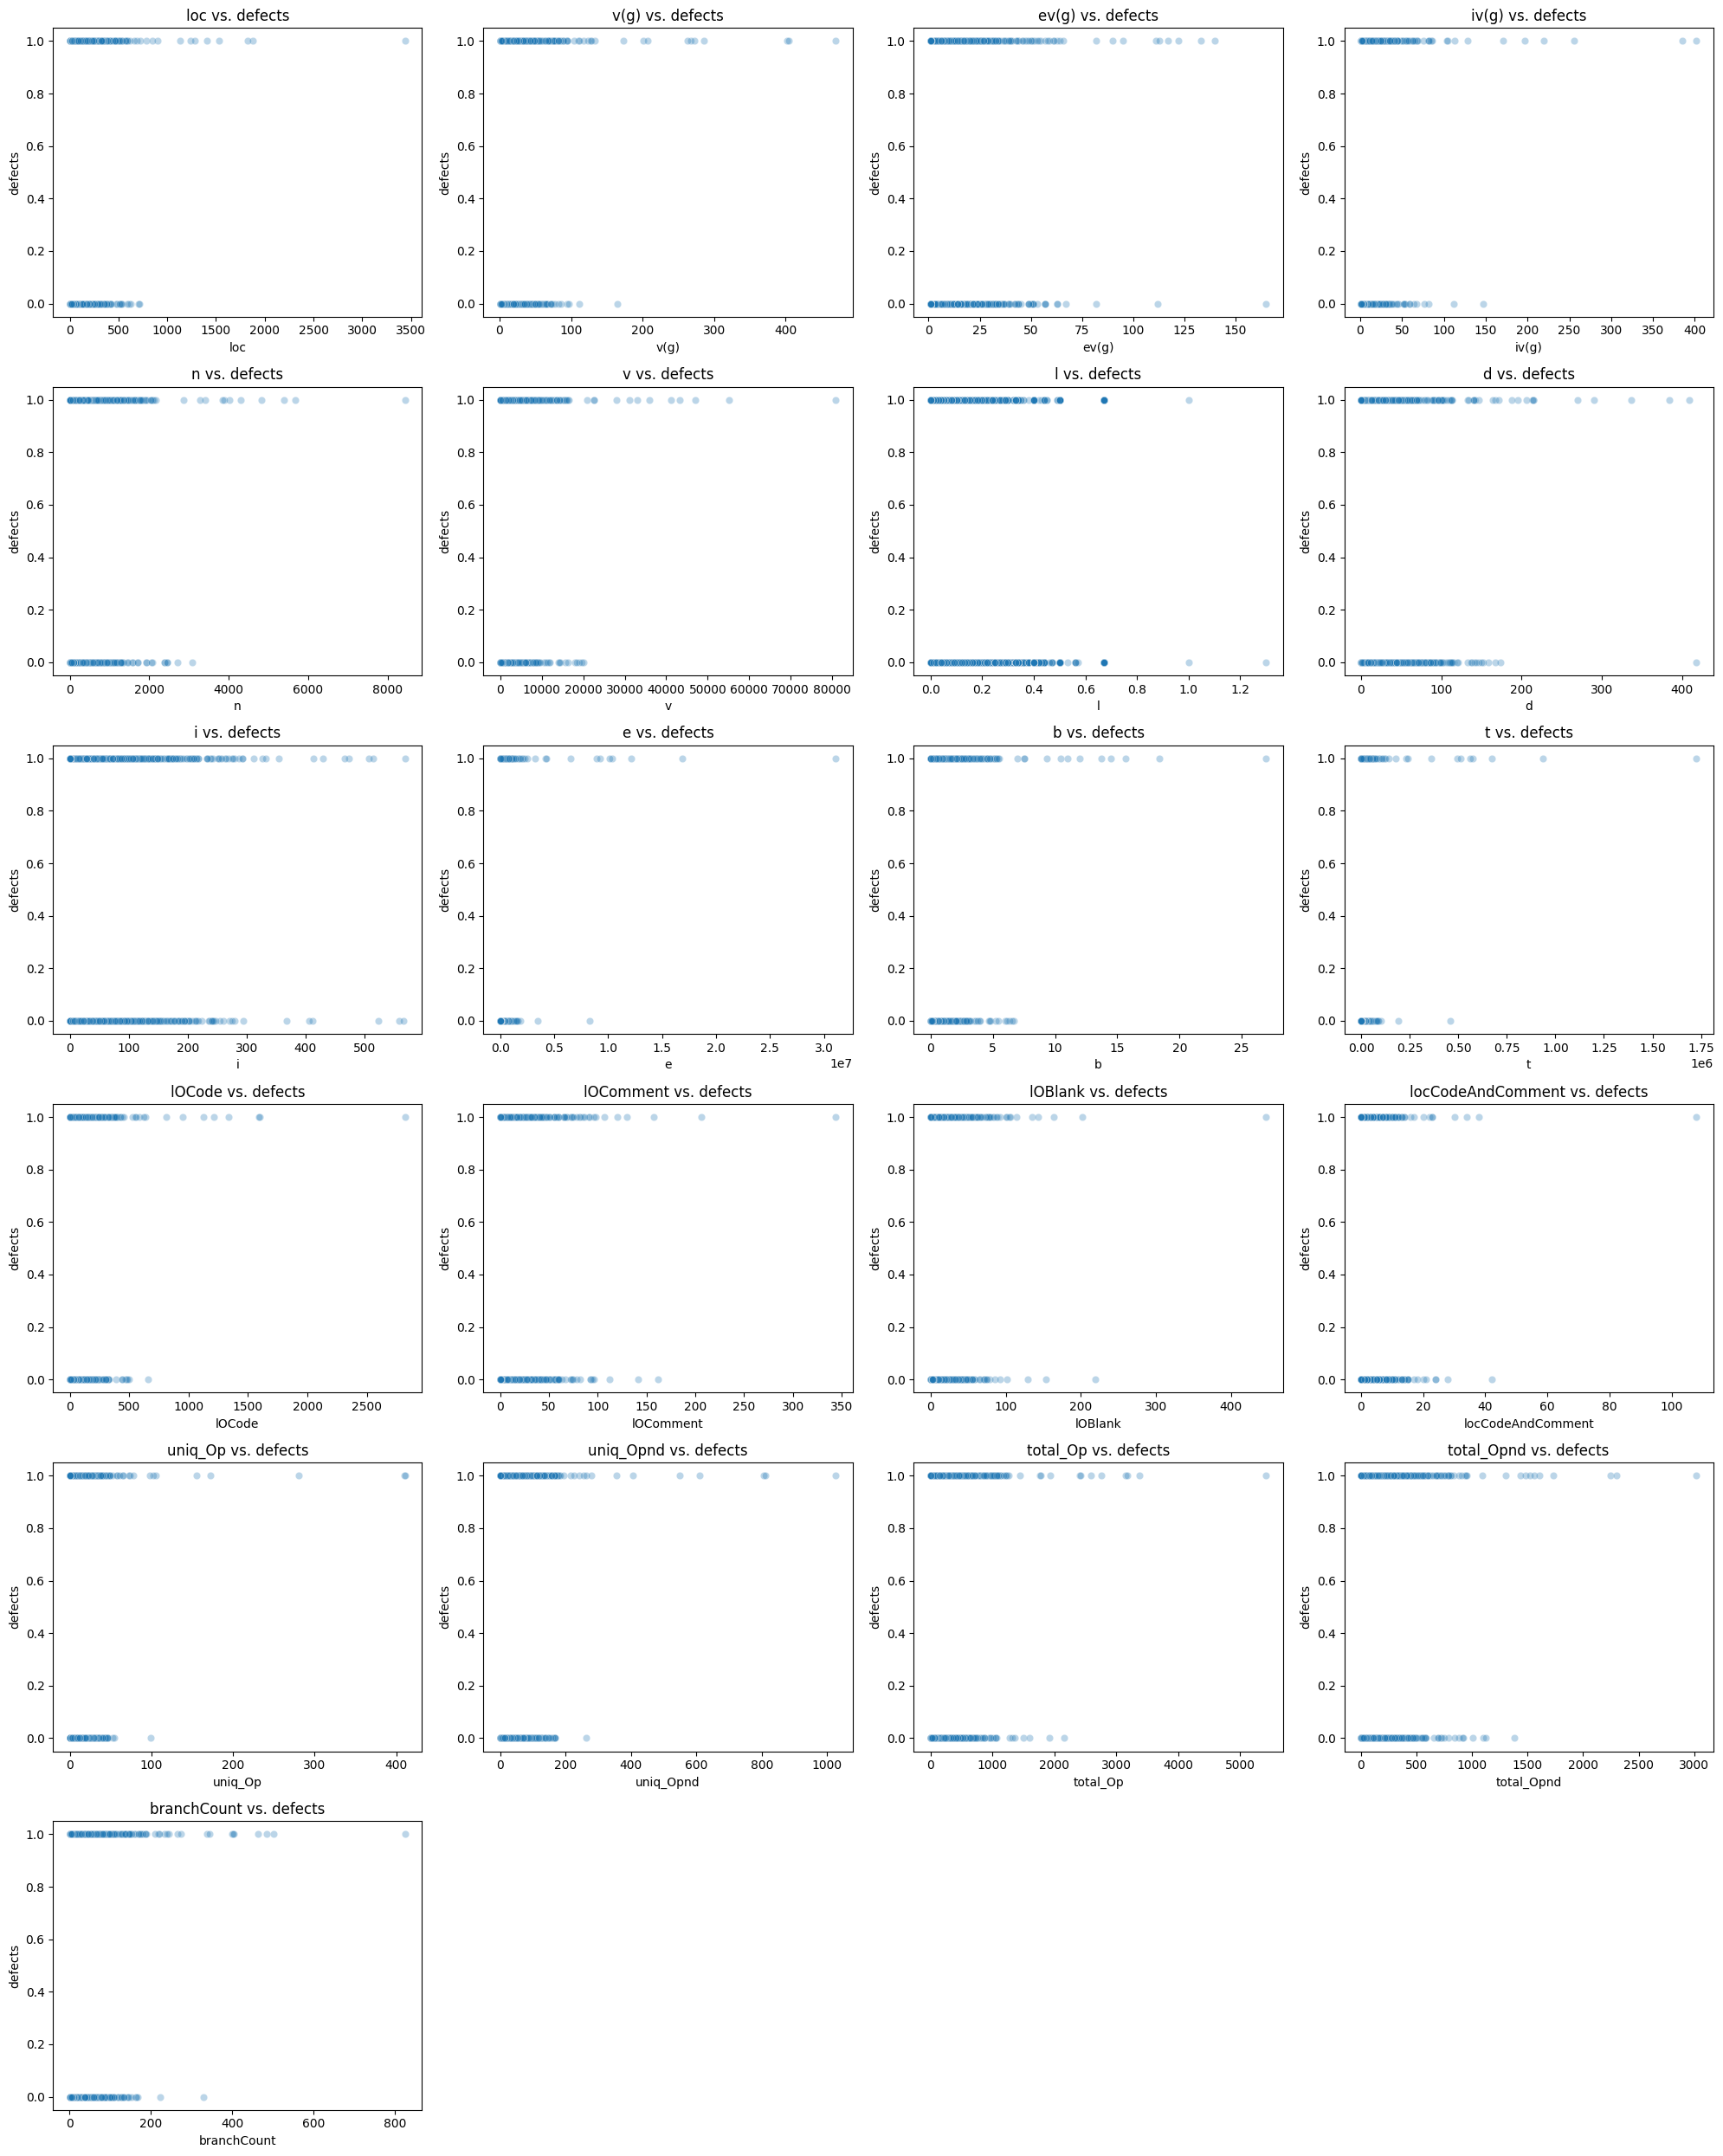

In [43]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_numerico):
    plt.subplot(6, 4, i + 1)
    sns.scatterplot(x=csv_file[col], y=csv_file['defects'], alpha=0.3)
    plt.title(f'{col} vs. defects')
    plt.xlabel(col)
    plt.ylabel('defects')
    plt.tight_layout()

plt.show()

Uso de Random Forest para calcular la incidencia de cada variable sobre la predicción

In [44]:
X = csv_file.drop(columns=['defects'])
y = csv_file['defects']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
0,loc,0.133939
8,i,0.056738
12,lOCode,0.055499
11,t,0.053710
9,e,0.052811
5,v,0.052633
7,d,0.051669
3,iv(g),0.051652
1,v(g),0.049488
18,total_Op,0.048447


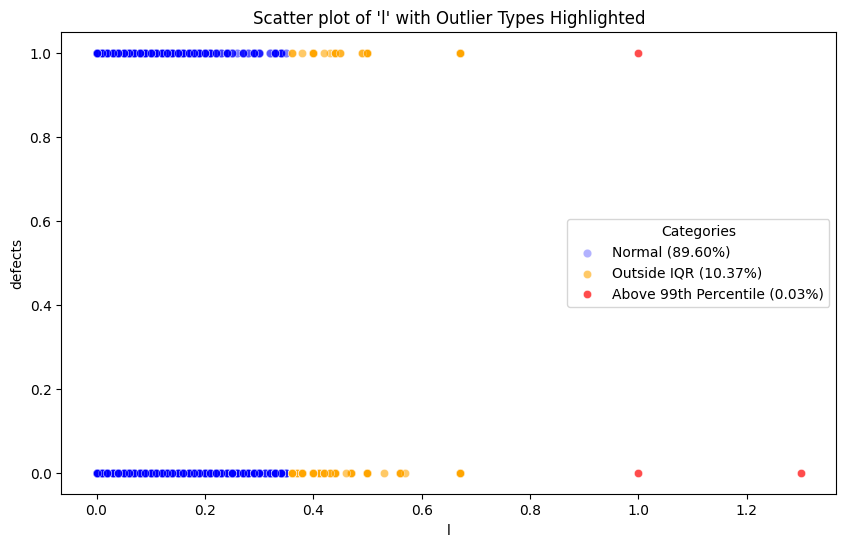

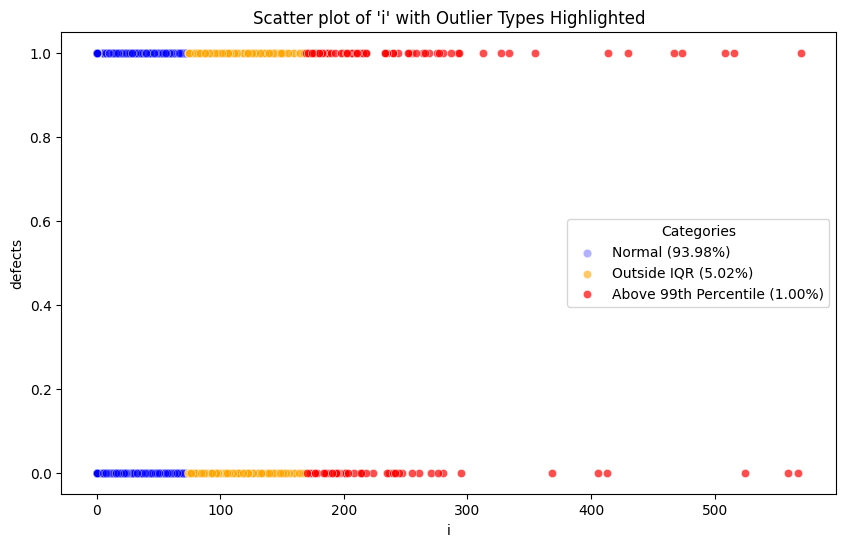

In [45]:
def plot_and_show_percentages(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    p99 = df[col].quantile(0.99)

    above_99 = df[col] > p99
    outside_iqr = ((df[col] > upper_bound) | (df[col] < lower_bound)) & (~above_99)
    normal = ~(above_99 | outside_iqr)

    total = len(df)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[normal][col], y=df[normal]['defects'], color='blue', alpha=0.3, label=f'Normal ({normal.sum()/total*100:.2f}%)')
    sns.scatterplot(x=df[outside_iqr][col], y=df[outside_iqr]['defects'], color='orange', alpha=0.6, label=f'Outside IQR ({outside_iqr.sum()/total*100:.2f}%)')
    sns.scatterplot(x=df[above_99][col], y=df[above_99]['defects'], color='red', alpha=0.7, label=f'Above 99th Percentile ({above_99.sum()/total*100:.2f}%)')

    plt.title(f"Scatter plot of '{col}' with Outlier Types Highlighted")
    plt.xlabel(col)
    plt.ylabel('defects')
    plt.legend(title='Categories')
    plt.show()

# Example usage
plot_and_show_percentages(csv_file, 'l')
plot_and_show_percentages(csv_file, 'i')

Remoción de locCodeAndComment por su baja incidencia y eliminación de valores extremos en l e i

In [46]:
df_limpio = csv_file.copy()
df_limpio = df_limpio.drop(columns=['locCodeAndComment'])

Q1_l = df_limpio['l'].quantile(0.25)
Q3_l = df_limpio['l'].quantile(0.75)
df_limpio['l'] = np.where(df_limpio['l'] < Q1_l, Q1_l, df_limpio['l'])
df_limpio['l'] = np.where(df_limpio['l'] > Q3_l, Q3_l, df_limpio['l'])

def cap_features(df, columns, percentile=99):
    df_capped = df.copy()
    for col in columns:
        upper = np.percentile(df_capped[col], percentile)
        df_capped[col] = np.where(df_capped[col] > upper, upper, df_capped[col])
    return df_capped

df_capped = cap_features(df_limpio, ['lOComment', 'b', 'i'])

df_limpio[['l','i', 'lOComment', 'l']].describe()

,l,i,lOComment,l
count,10880.000000,10880.00000,10880.000000,10880.000000
mean,0.089040,29.43885,2.738787,0.089040
std,0.052416,34.42332,9.010486,0.052416
min,0.030000,0.00000,0.000000,0.030000
25%,0.030000,11.86000,0.000000,0.030000
50%,0.080000,21.92500,0.000000,0.080000
75%,0.160000,36.78000,2.000000,0.160000
max,0.160000,569.78000,344.000000,0.160000


Análisis de correlación Pearson y Spearman entre features y el target

In [49]:
features = df_limpio.drop(columns=['defects', 'is_outlier'], errors='ignore')

pearson_corr = features.corrwith(df_capped['defects'], method='pearson')
spearman_corr = features.corrwith(df_capped['defects'], method='spearman')

correlation_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
}).sort_values(by='Pearson', ascending=False)

print(correlation_df)

              Pearson  Spearman
loc          0.245437  0.296057
branchCount  0.222754  0.238842
uniq_Opnd    0.211952  0.177187
v(g)         0.208670  0.238918
n            0.204087  0.172219
total_Opnd   0.203825  0.170555
total_Op     0.200987  0.172656
lOBlank      0.199489  0.207032
lOCode       0.195857  0.180105
i            0.192643  0.160787
b            0.189318  0.179515
v            0.189113  0.174455
iv(g)        0.181981  0.243118
ev(g)        0.172935  0.164700
d            0.169442  0.144535
lOComment    0.161131  0.165172
uniq_Op      0.158834  0.153869
t            0.086092  0.166650
e            0.086092  0.166625
l           -0.197038 -0.203015


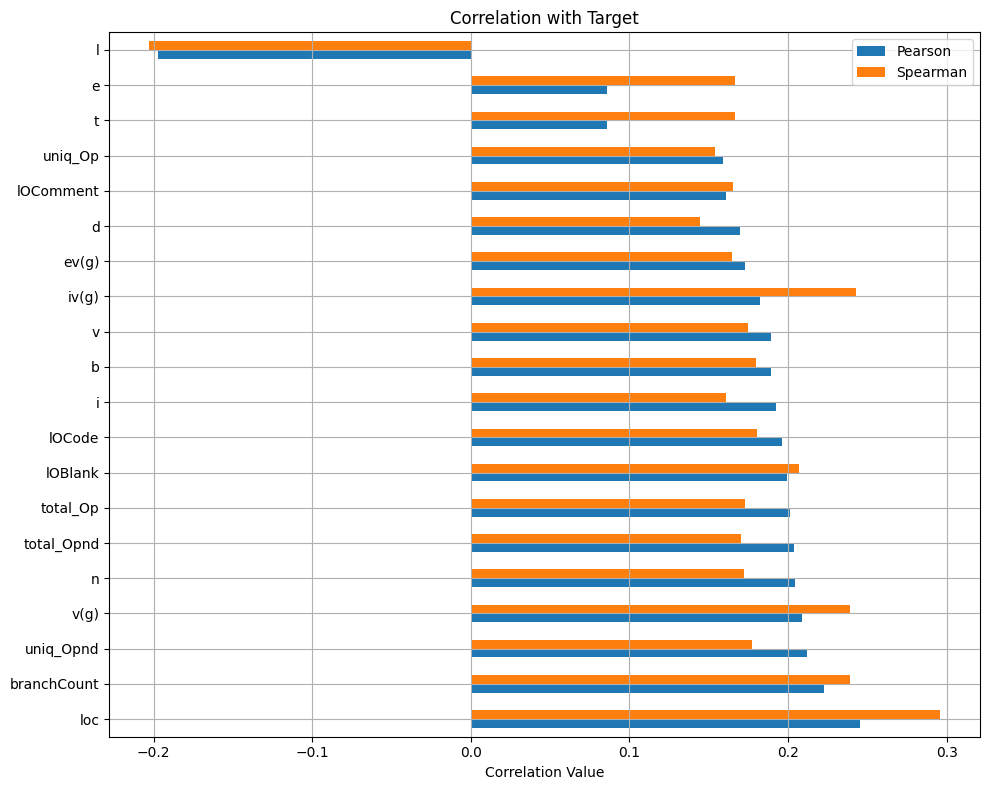

In [50]:
correlation_df.plot(kind='barh', figsize=(10, 8), title='Correlation with Target')
plt.xlabel('Correlation Value')
plt.grid(True)
plt.tight_layout()
plt.show()

Entrenamiento de Random Forest para predicción

In [53]:
X = df_limpio.drop(columns=['defects', 'is_outlier'], errors='ignore')
y = df_limpio['defects']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [76]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [79]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
y_pred_adj = (y_proba >= 0.3).astype(int)

Resultados con Random Tree puro

In [77]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("📊 Evaluation Metrics:")
print(f"Accuracy       : {acc:.3f}")
print(f"Precision      : {prec:.3f}")
print(f"Recall (Sensitivity) : {rec:.3f}")
print(f"F1 Score       : {f1:.3f}")
print(f"ROC AUC Score  : {auc:.3f}")

📊 Evaluation Metrics:
Accuracy       : 0.682
Precision      : 0.325
Recall (Sensitivity) : 0.596
F1 Score       : 0.421
ROC AUC Score  : 0.719


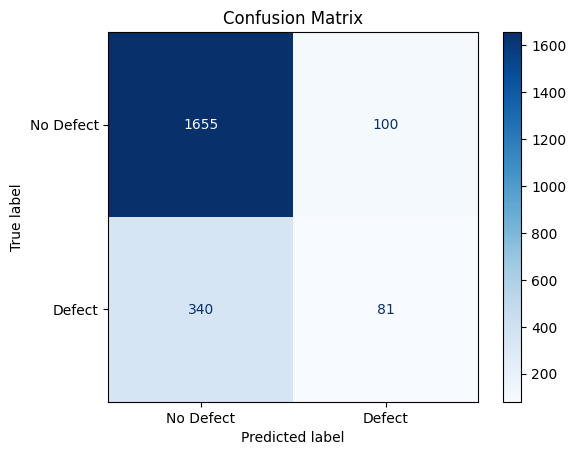

In [57]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Defect", "Defect"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Resultados con Random Tree + Threshold Tuning (0.5 a 0.3)

In [60]:
acc = accuracy_score(y_test, y_pred_adj)
prec = precision_score(y_test, y_pred_adj)
rec = recall_score(y_test, y_pred_adj)
f1 = f1_score(y_test, y_pred_adj)
auc = roc_auc_score(y_test, y_proba)

print("📊 Evaluation Metrics:")
print(f"Accuracy       : {acc:.3f}")
print(f"Precision      : {prec:.3f}")
print(f"Recall (Sensitivity) : {rec:.3f}")
print(f"F1 Score       : {f1:.3f}")
print(f"ROC AUC Score  : {auc:.3f}")

📊 Evaluation Metrics:
Accuracy       : 0.740
Precision      : 0.365
Recall (Sensitivity) : 0.466
F1 Score       : 0.409
ROC AUC Score  : 0.722


Resultado Random Tree + Threshold Tuning + SMOTE (Datos sintéticos de la minoría)


In [62]:
X = df_limpio.drop(columns=['defects', 'is_outlier'], errors='ignore')
y = df_limpio['defects']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
y_pred_adj = (y_proba >= 0.3).astype(int)

acc = accuracy_score(y_test, y_pred_adj)
prec = precision_score(y_test, y_pred_adj)
rec = recall_score(y_test, y_pred_adj)
f1 = f1_score(y_test, y_pred_adj)
auc = roc_auc_score(y_test, y_proba)

print("📊 Evaluation Metrics:")
print(f"Accuracy       : {acc:.3f}")
print(f"Precision      : {prec:.3f}")
print(f"Recall (Sensitivity) : {rec:.3f}")
print(f"F1 Score       : {f1:.3f}")
print(f"ROC AUC Score  : {auc:.3f}")

📊 Evaluation Metrics:
Accuracy       : 0.671
Precision      : 0.332
Recall (Sensitivity) : 0.689
F1 Score       : 0.448
ROC AUC Score  : 0.744


Resultados sólo Rando Tree + SMOTE

In [63]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("📊 Evaluation Metrics:")
print(f"Accuracy       : {acc:.3f}")
print(f"Precision      : {prec:.3f}")
print(f"Recall (Sensitivity) : {rec:.3f}")
print(f"F1 Score       : {f1:.3f}")
print(f"ROC AUC Score  : {auc:.3f}")

📊 Evaluation Metrics:
Accuracy       : 0.789
Precision      : 0.450
Recall (Sensitivity) : 0.404
F1 Score       : 0.426
ROC AUC Score  : 0.744


Resultados Random Tree + SMOTE + Hiperparámetros (RandomSearch)

In [68]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5, 0.75]
}

scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring=scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

X = df_limpio.drop(columns=['defects', 'iso_outlier'], errors='ignore')
y = df_limpio['defects']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)
print("Best F1 score (CV):", random_search.best_score_)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print("Test set metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 10}
Best F1 score (CV): 0.43524801521260265
Test set metrics:
Accuracy: 0.759
Precision: 0.399
Recall: 0.487
F1 Score: 0.439
ROC AUC: 0.736


Resultados Random Tree + SMOTE + Hiperparámetros (GridSearch)

In [70]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2', 0.5]
}

scorer = make_scorer(f1_score)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)

X = df_limpio.drop(columns=['defects', 'iso_outlier'], errors='ignore')
y = df_limpio['defects']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best F1 score (CV):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print("📊 Test Set Evaluation:")
print(f"Accuracy  : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision : {precision_score(y_test, y_pred):.3f}")
print(f"Recall    : {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score  : {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC   : {roc_auc_score(y_test, y_proba):.3f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best F1 score (CV): 0.43830997298678565
📊 Test Set Evaluation:
Accuracy  : 0.757
Precision : 0.398
Recall    : 0.494
F1 Score  : 0.441
ROC AUC   : 0.737


Random Tree con Test Size 10%

In [80]:
X = df_limpio.drop(columns=['defects', 'is_outlier'], errors='ignore')
y = df_limpio['defects']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("📊 Evaluation Metrics:")
print(f"Accuracy       : {acc:.3f}")
print(f"Precision      : {prec:.3f}")
print(f"Recall (Sensitivity) : {rec:.3f}")
print(f"F1 Score       : {f1:.3f}")
print(f"ROC AUC Score  : {auc:.3f}")

📊 Evaluation Metrics:
Accuracy       : 0.802
Precision      : 0.473
Recall (Sensitivity) : 0.210
F1 Score       : 0.290
ROC AUC Score  : 0.710


Random Tree con Test Size 30% + SMOTE + Threshold Tuning

In [85]:
X = df_limpio.drop(columns=['defects', 'is_outlier'], errors='ignore')
y = df_limpio['defects']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
y_pred_adj = (y_proba >= 0.3).astype(int)

acc = accuracy_score(y_test, y_pred_adj)
prec = precision_score(y_test, y_pred_adj)
rec = recall_score(y_test, y_pred_adj)
f1 = f1_score(y_test, y_pred_adj)
auc = roc_auc_score(y_test, y_proba)

print("📊 Evaluation Metrics:")
print(f"Accuracy       : {acc:.3f}")
print(f"Precision      : {prec:.3f}")
print(f"Recall (Sensitivity) : {rec:.3f}")
print(f"F1 Score       : {f1:.3f}")
print(f"ROC AUC Score  : {auc:.3f}")

📊 Evaluation Metrics:
Accuracy       : 0.678
Precision      : 0.336
Recall (Sensitivity) : 0.678
F1 Score       : 0.449
ROC AUC Score  : 0.747
